In [70]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Data setup

## Setting up dataframes

In [81]:
lapData  = pd.read_table('./racedata.csv',sep=',').sample(frac=1) # scramble data
# fastestLaps = pd.read_table('./fastestLaps.csv',sep=',').sample(frac=1)
# Preview
lapData['constructor'] = lapData['constructor'].astype(np.str0)
lapData['avglap']      = lapData['avglap'].astype(np.float64)
lapData['year']        = lapData['year'].astype(np.int64)
lapData['circuit']     = lapData['circuit'].astype(np.str0)
lapData['podium']      = lapData['podium'].astype(np.int8)

# fastestLaps['avglap']  = fastestLaps['avglap'].astype(np.str0)
# fastestLaps['year']    = fastestLaps['year'].astype(np.int64)
# fastestLaps['circuit'] = fastestLaps['circuit'].astype(np.str0)
# fastestLaps['podium']  = fastestLaps['podium'].astype(np.int8)

# data = pd.concat([lapData,fastestLaps])
data = lapData

## Feature Relationships

### Constructor vs Podiums

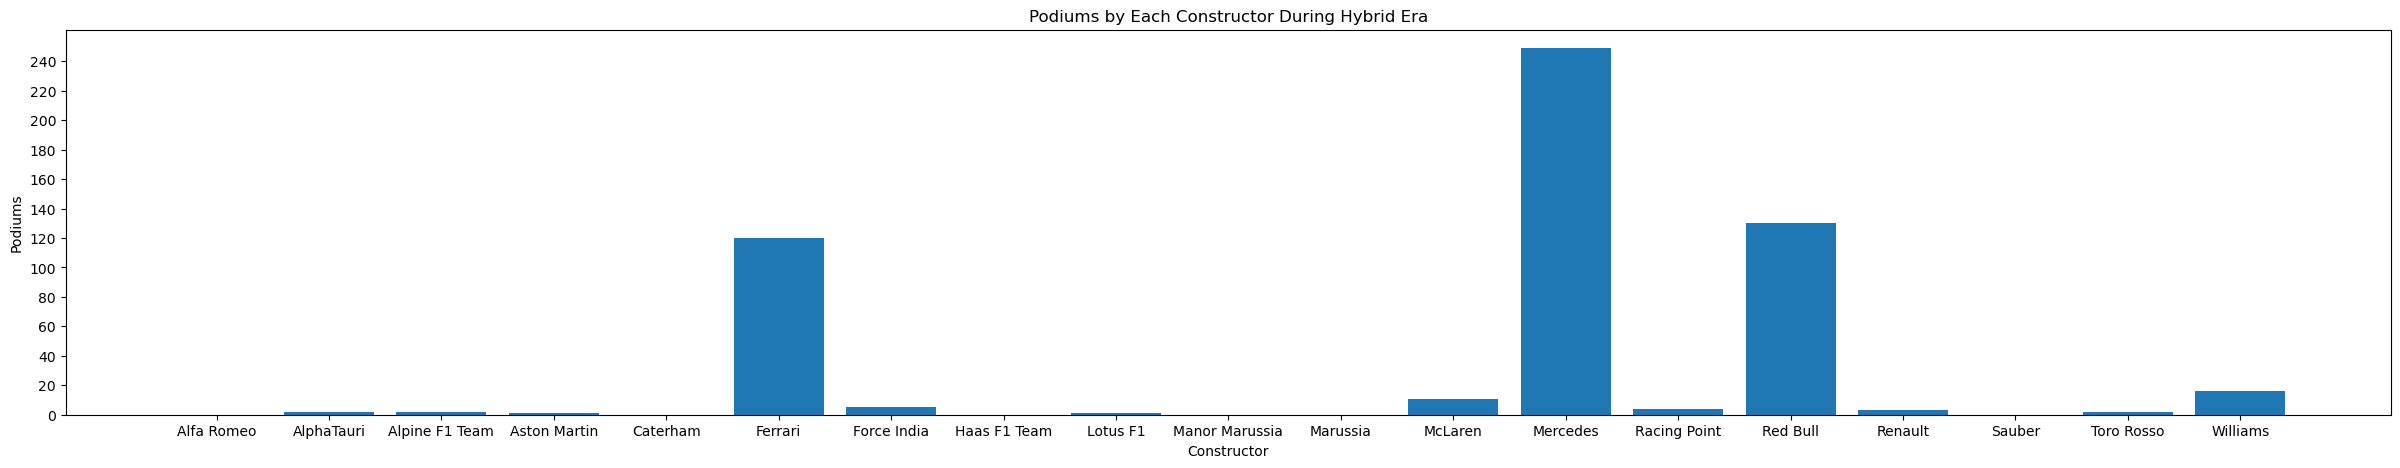

In [ ]:
podiums = lapData.groupby('constructor')['podium'].sum()

fig, ax = plt.subplots(figsize=(30, 5))
ax.bar(podiums.index, podiums.values)

ax.set_xlabel('Constructor')
ax.set_ylabel('Podiums')
ax.set_title('# of Podiums by Each Constructor During Hybrid Era')
ax.yaxis.set_ticks([i for i in range(0, 250,20)])

plt.show()

As expected we can see that there's a strong relationship between constructors and podiums. Using constructor as an independant variable should make predictions easier since if the constructor isn't Ferrari, Mercedes or RedBull it's fair to assume significantly lower odds of being on the podium.

## General Average Lap at a given circuit vs Podium

We'll be looking at Silverstone, Spa-Francorchamps and Barcelona-Catalunya because they were raced in every hybrid era season, providing more data to analyze.

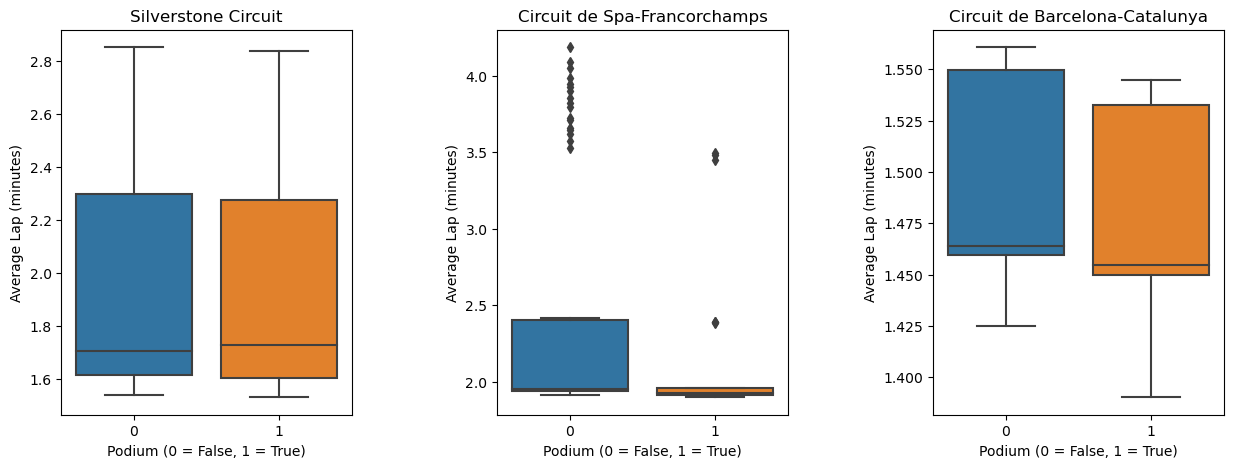

In [83]:
circuits = ['Silverstone Circuit','Circuit de Spa-Francorchamps','Circuit de Barcelona-Catalunya']

figure, axes = plt.subplots(nrows=1, ncols=len(circuits), figsize=(15,5))

# Create a box-plot for each circuit
for i, circuit in enumerate(circuits):
    circuitData = lapData[(lapData['circuit'] == circuit)] # Filter for specific circuit
    circuitData['avglap'] = circuitData['avglap'] / 60000 # Convert to minutes
    sns.boxplot(x='podium', y='avglap', data=circuitData, ax=axes[i])
    
    axes[i].set_title(circuit)
    axes[i].set_xlabel('Podium (0 = False, 1 = True)')
    axes[i].set_ylabel('Average Lap (minutes)')

plt.subplots_adjust(wspace=0.5)

plt.show()

These boxplots are showing a lot of overlap indicating theres siginificant varaince in the average laptime of podium and non podium finishes. This does make sense as cars typically increase their performance season-to-season, in turn raising the bar for the laptimes required to make it to the podium. Below we'll look at single season results.

## Average lap at a given circuit during a specific season vs Podium

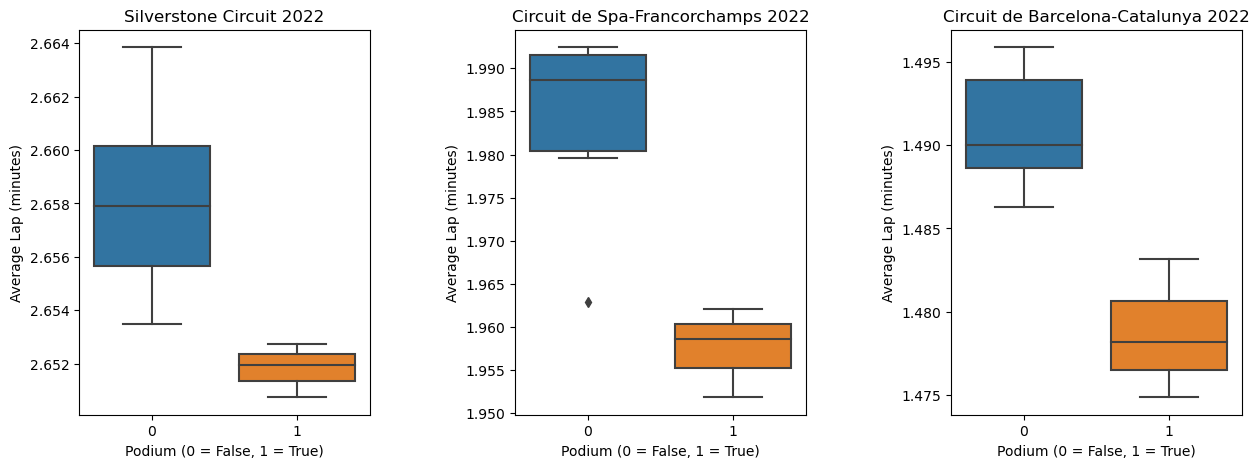

In [84]:
circuits = ['Silverstone Circuit','Circuit de Spa-Francorchamps','Circuit de Barcelona-Catalunya']
year = 2022

figure, axes = plt.subplots(nrows=1, ncols=len(circuits), figsize=(15,5))

# Create a box-plot for each circuit
for i, circuit in enumerate(circuits):
    circuitData = lapData[(lapData['circuit'] == circuit) & (lapData['year'] == year)] # Filter for specific circuit and season
    circuitData['avglap'] = circuitData['avglap'] / 60000 # Convert to minutes
    sns.boxplot(x='podium', y='avglap', data=circuitData, ax=axes[i])
    
    axes[i].set_title(f'{circuit} {year}')
    axes[i].set_xlabel('Podium (0 = False, 1 = True)')
    axes[i].set_ylabel('Average Lap (minutes)')

plt.subplots_adjust(wspace=0.5)

plt.show()


These boxplots give a better idea of the required average laptime to finish on the podium.

# Finding ideal model + Optimization

### Split test / train data


In [119]:
YData = data['podium']

# X Data for model with constructor, circuit, year and avglap as features
XDataModel0 =  pd.get_dummies(data,prefix=['constructor','circuit'],columns=['constructor','circuit']).astype('float')

# X Data for model with circuit and avglap as features
lapData1 = data[['avglap','circuit']]
XDataModel1 =  pd.get_dummies(lapData1,prefix=['circuit'],columns=['circuit']).astype('float')


In [120]:
XTrainModel0, XTestModel0, YTrainModel0, YTestModel0 = train_test_split(XDataModel0, YData, test_size=0.2, random_state=2)

XTrainModel1, XTestModel1, YTrainModel1, YTestModel1 = train_test_split(XDataModel1, YData, test_size=0.2, random_state=4)

#### Utillities

In [121]:
from sklearn.model_selection import GridSearchCV

regressionParamGrid = [
    {
        'penalty' : ['l1','l2','elasticnet','none'],
        'C' : np.logspace(-4,4,20),
        'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
        'max_iter' : [100,1000,2500,5000]
    }
]

treeParamGrid = [
    {
        'criterion' : ['gini', 'entropy', 'mse', 'mae'],
        'splitter'  : ['best', 'random'],
        'max_depth': [None] + list(range(1, 11)),
        'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'max_features': [None, 'auto', 'sqrt', 'log2'],
        'ccp_alpha': [0.0, 0.001, 0.01, 0.1],
        'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
]

## Regression Model 1 

### Features: Constructor, Avglap, Year and circuit

In [122]:
# Init model
regModel0 = LogisticRegression()
regModel0.fit(XTrainModel0,YTrainModel0)
# Test
print(regModel0.score(XTestModel0,YTestModel0))

0.7052341597796143


In [123]:
regModel0Predictions = regModel0.predict(XTestModel0)
print(metrics.confusion_matrix(YTestModel0,regModel0Predictions))

[[256   0]
 [107   0]]


## Regression Model 2

### Features: Avglap and circuit

In [124]:
# Init model
regModel1 = LogisticRegression()
regModel1.fit(XTrainModel1,YTrainModel1)
# Test
print(regModel1.score(XTestModel1,YTestModel1))

0.6942148760330579


In [125]:
regModel2Predictions = regModel1.predict(XTestModel1)
print(metrics.confusion_matrix(YTestModel1,regModel2Predictions))

[[252   0]
 [111   0]]


## Regression Model Summary

From the model scores and confusion matrices we can see that a regression model isn't suitable for predicting podiums from the chosen features. This could be cause by overfitting due to lack of training data, as well as the lack of linear relationship between the selected features and the dependant variable.

## Decision Tree Model 1

### Features: Constructor, Avglap, Year and circuit

In [136]:
from sklearn.tree import DecisionTreeClassifier
treeModel0 = DecisionTreeClassifier()
treeModel0.fit(XTrainModel0,YTrainModel0)
treeModel0.score(XTestModel0,YTestModel0)

1.0

In [118]:
treePredictions0 = treeModel0.predict(XTestModel0)
print(metrics.confusion_matrix(YTestModel0,treePredictions0))

[[256   0]
 [  0 107]]


## Decision Tree Model 2

### Features: Avglap and circuit

In [137]:
treeModel1 = DecisionTreeClassifier()
treeModel1.fit(XTrainModel1,YTrainModel1)
treeModel1.score(XTestModel1,YTestModel1)

0.7823691460055097

In [133]:
treePredictions1 = treeModel1.predict(XTestModel1)
print(metrics.confusion_matrix(YTestModel1,treePredictions1))

[[218  34]
 [ 49  62]]


## Decision Tree Model Summary

From the scores and confusion matrices above we can see that the decision tree models were significantly more effective in predicting podiums from the given features and weren't guessing true for ever case.

## Optimizing Decision Tree Hyperparameters

In [140]:
clf = GridSearchCV(treeModel1,param_grid=treeParamGrid,cv=3,verbose=True,n_jobs=1)
bestParams = clf.fit(XTrainModel1,YTrainModel1)
bestParams.best_estimator_

Fitting 3 folds for each of 760320 candidates, totalling 2280960 fits


DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                       criterion='entropy', max_features='auto')

In [142]:
model = DecisionTreeClassifier(ccp_alpha=0.001,class_weight='balanced',criterion='entropy', max_features='auto')
model.fit(XTrainModel1,YTrainModel1)
print(model.score(XTestModel1,YTestModel1))
modelPredictions = model.predict(XTestModel1)
print(metrics.confusion_matrix(YTestModel1,modelPredictions))

0.8044077134986226
[[218  34]
 [ 37  74]]


## Saving model

In [143]:
import pickle
pklFile = 'model.pkl'
with open(pklFile,'wb') as file:
    pickle.dump(model,file)